In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
colunas = ['CO_CATEGAD','CO_GRUPO','CO_REGIAO_CURSO','CO_UF_CURSO','TP_SEXO','TP_PRES','NT_GER','QE_I02','QE_I04','QE_I05','QE_I08','QE_I13','QE_I15','QE_I17','NU_IDADE','CO_CURSO','CO_MODALIDADE','ANO_FIM_EM','ANO_IN_GRAD','CO_TURNO_GRADUACAO'] #selecionando apenas as colunas necessarias

microdados = pd.read_csv('MICRODADOS_ENADE_2017.csv',sep=';',usecols=colunas,decimal=',') #carregando arquivo, apenas com as colunas desejadas, usando como separador ';'

In [3]:
microdados_sul = microdados.query('CO_GRUPO == 72 | CO_GRUPO == 79 | CO_GRUPO == 4003 | CO_GRUPO == 4004 | CO_GRUPO == 4005 | CO_GRUPO == 4006 | CO_GRUPO == 6409') #filtrando alunos de cursos da area de TI

In [4]:
microdados_sul = microdados_sul.query('CO_REGIAO_CURSO == 4') #filtrando apenas alunos cuja IES se localiza na região sul do país

In [5]:
microdados_sul = microdados_sul.astype({'TP_PRES':int}) #convertendo tipo dos dados

In [6]:
microdados_sul = microdados_sul.query('TP_PRES == 555') #selecionando apenas alunos presentes no ENADE com nota valida

In [7]:
microdados_sul = microdados_sul.loc[microdados_sul.QE_I15.notnull()] #removendo alunos que deixaram questionario em branco

In [8]:
microdados_sul = microdados_sul.loc[microdados_sul.NT_GER.notnull()] #removendo alunos com notas em branco

In [9]:
#Transformaçao
microdados_sul['CO_CATEGAD'].replace({1:0,2:0,3:0},inplace=True) #publica 
microdados_sul['CO_CATEGAD'].replace({4:1,5:1,7:1},inplace=True) #privada

In [10]:
microdados_sul['CO_UF_CURSO'].replace({41:'PR',42:'SC',43:'RS'},inplace=True) #mudando codigo da UF para sigla

In [11]:
#agrupando faixas de renda
microdados_sul['QE_I08'].replace({'B':'A'},inplace=True) #ate 3 salarios
microdados_sul['QE_I08'].replace({'C':'B','D':'B'},inplace=True) #3 a 6 salarios 
microdados_sul['QE_I08'].replace({'E':'C','F':'C'},inplace=True) #6 a 30 salarios 
microdados_sul['QE_I08'].replace({'G':'D'},inplace=True) #mais de 30 salarios 

In [12]:
#separando por tipo de ensino medio
microdados_sul['QE_I17'].replace({'D':'A'},inplace=True) #todo tempo ou maior parte pub
microdados_sul['QE_I17'].replace({'E':'B'},inplace=True) #todo tempo ou maior parte privada
microdados_sul['QE_I17'].replace({'F':'C'},inplace=True) #todo tempo ou maior parte exterior

In [13]:
cursos_dict = {72: 'ADS', 79:'RC',4003: 'EC', 4004:'BCC',4005:'LCC',4006: 'SI',6409: 'GTI'}

In [14]:
cursos_abrev_dict = {'ADS': 'Tecnologia em Análise e Desenvolvimento de Sistemas', 'RC':'Tecnologia em Redes de Computadores','EC': 'Engenharia Da Computação', 'BCC':'Ciência Da Computação (Bacharelado)','LCC':'Ciência da Computação (Licenciatura)','SI': 'Sistemas De Informação','GTI': 'Tecnologia em Gestão da Tecnologia da Informação'}

In [15]:
descricao_cursos = pd.DataFrame.from_dict(cursos_abrev_dict,orient='index',columns=['Descrição'])

In [16]:
#Quantidade de alunos por curso
alunos_por_curso = microdados_sul['CO_GRUPO'].value_counts(sort=False).to_frame('Quantidade de alunos').rename(index=cursos_dict)

In [17]:
alunos_por_curso = alunos_por_curso.rename_axis('Curso',axis='columns').sort_index()

In [18]:
#Quantidade de alunos em publicas e privadas na regiao
qnt_pub_privada = microdados_sul['CO_CATEGAD'].value_counts().to_frame('Quantidade de alunos').rename(index={0:'Pública',1:'Privada'}).rename_axis('',axis='columns')

In [19]:
#Quantidade de alunos em publicas e privadas por curso
curso_pub_privada = microdados_sul.groupby(['CO_GRUPO']).CO_CATEGAD.value_counts().unstack().rename(index=cursos_dict,columns={0:'Pública',1:'Privada'}).rename_axis('Curso',axis='columns').rename_axis('')

In [20]:
qnt_pub_privada_curso = pd.merge(alunos_por_curso,curso_pub_privada,left_index=True,right_index=True)

In [21]:
cod_cursos = microdados_sul.groupby('CO_GRUPO').CO_CURSO.value_counts().to_frame().rename(index=cursos_dict)

In [22]:
cursos_area = microdados_sul.groupby('CO_GRUPO').CO_CURSO.nunique().to_frame().rename(index=cursos_dict) #quantidade de cursos por area

In [23]:
microdados_sul.groupby('CO_CATEGAD').CO_CURSO.nunique() #pub e privado

CO_CATEGAD
0     87
1    226
Name: CO_CURSO, dtype: int64

In [24]:
microdados_sul.groupby(['CO_GRUPO','CO_CATEGAD']).CO_CURSO.nunique()

CO_GRUPO  CO_CATEGAD
72        0             27
          1             59
79        0              3
          1             21
4003      0             10
          1             14
4004      0             26
          1             39
4005      0              6
          1              3
4006      0             14
          1             73
6409      0              1
          1             17
Name: CO_CURSO, dtype: int64

In [25]:
microdados_sul.groupby('CO_MODALIDADE').CO_CURSO.nunique()

CO_MODALIDADE
0     14
1    299
Name: CO_CURSO, dtype: int64

In [26]:
aluno_curso_estado = microdados_sul.groupby('CO_GRUPO')['CO_UF_CURSO'].value_counts().unstack().rename(index=cursos_dict) #alunos por curso em cada estado

In [27]:
###NOVO --- EXTRA
diretorio = '/questao_extra'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

qnt_pub_privada.to_csv('.{}/{}.csv'.format(diretorio,'alunos_pub_privada'),index=True)
descricao_cursos.to_csv('.{}/{}.csv'.format(diretorio,'descricao_cursos'),index=True)
cod_cursos.to_csv('.{}/{}.csv'.format(diretorio,'codigo_curso_area'),index=True)
cursos_area.to_csv('.{}/{}.csv'.format(diretorio,'qnt_cursos_area'),index=True)
aluno_curso_estado.to_csv('.{}/{}.csv'.format(diretorio,'qnt_aluno_curso_area'),index=True)
qnt_pub_privada_curso.to_csv('.{}/{}.csv'.format(diretorio,'qnt_pub_privada_curso'),index=True)

In [28]:
#quantidade de alunos por raça
raca_dict = {'A':'Branca','B':'Preta','C':'Amarela','D':'Parda','E':'Indígena','F':'Não declarada'}
qnt_aluno_raca = microdados_sul['QE_I02'].value_counts().to_frame('Quantidade de alunos').rename(index=raca_dict)

Text(0, 0.5, 'Porcentagem de alunos')

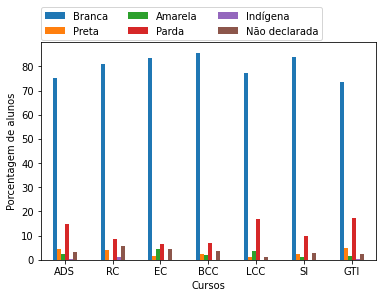

In [29]:
#Questao1 - Qual a quantidade de cada raça por curso?

qnt_raca_curso_rs = (microdados_sul.groupby(['CO_GRUPO']).QE_I02.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
qnt_raca_curso_rs.set_xticklabels(cursos_abrev_dict.keys())
qnt_raca_curso_rs.legend(labels=raca_dict.values(),bbox_to_anchor=(0,1.01),borderaxespad=0,loc="lower left",ncol=3)
qnt_raca_curso_rs.set_xlabel('Cursos')
qnt_raca_curso_rs.set_ylabel('Porcentagem de alunos')

Text(0, 0.5, 'Porcentagem de alunos')

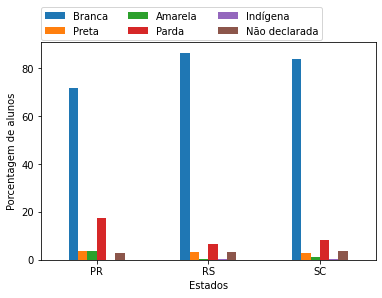

In [30]:
raca_estados = (microdados_sul.groupby(['CO_UF_CURSO']).QE_I02.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
raca_estados.legend(labels=raca_dict.values(),bbox_to_anchor=(0,1.01),borderaxespad=0,loc="lower left",ncol=3)
raca_estados.set_xlabel('Estados')
raca_estados.set_ylabel('Porcentagem de alunos')

In [31]:
cotista_dict = {'A':'Não','B':'Étnico-racial','C':'Renda','D':'Escola pública','E':'2+ critérios','F':'Outro sistema'}

In [32]:
cor_cota = (microdados_sul.groupby(['QE_I02']).QE_I15.value_counts(normalize=True).unstack().fillna(0).round(4)*100).rename(index=raca_dict,columns=cotista_dict)
cor_cota

QE_I15,Não,Étnico-racial,Renda,Escola pública,2+ critérios,Outro sistema
QE_I02,,,,,,
Branca,83.35,0.20,4.20,8.51,2.59,1.14
Preta,75.42,6.78,5.08,3.39,7.63,1.69
Amarela,85.40,0.00,4.38,8.76,0.73,0.73
Parda,73.23,3.24,7.60,9.34,5.60,1.00
Indígena,80.00,0.00,10.00,0.00,10.00,0.00
Não declarada,86.97,1.68,2.94,6.30,1.26,0.84


In [33]:
diretorio = '/questao1'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

cor_cota.to_csv('.{}/{}.csv'.format(diretorio,'porcentagem_cor_cota'),index=True)
qnt_aluno_raca.to_csv('.{}/{}.csv'.format(diretorio,'quantidade_aluno_raca'),index=True)
qnt_raca_curso_rs.get_figure().savefig('.{}/{}.png'.format(diretorio,'quantidade_aluno_raca_curso'),bbox_extra_artists=(qnt_raca_curso_rs.get_legend(),), bbox_inches='tight',dpi=300)

In [34]:
#quantidade por sexo
sexo_dict = {'F':'Feminino','M':'Masculino'}
qnt_sexo = microdados_sul['TP_SEXO'].value_counts().to_frame('Quantidade de alunos').rename(index=sexo_dict)

Text(0, 0.5, 'Porcentagem de alunos')

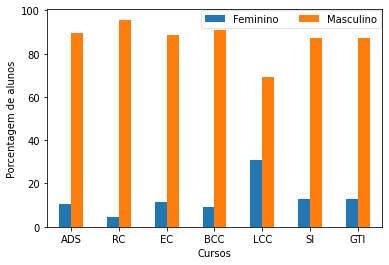

In [35]:
#Questao2 - Qual a presença de cada sexo por curso?

sexo_curso_pr = (microdados_sul.groupby(['CO_GRUPO']).TP_SEXO.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
sexo_curso_pr.set_xticklabels(cursos_abrev_dict.keys())
sexo_curso_pr.legend(labels=sexo_dict.values(),bbox_to_anchor=(1,1),borderaxespad=0.1,loc="upper right",framealpha=0.5,fontsize=10,ncol=2)
sexo_curso_pr.set_xlabel('Cursos')
sexo_curso_pr.set_ylabel('Porcentagem de alunos')

In [36]:
diretorio = '/questao2'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

qnt_sexo.to_csv('.{}/{}.csv'.format(diretorio,'quantidade_aluno_sexo'),index=True)
sexo_curso_pr.get_figure().savefig('.{}/{}.png'.format(diretorio,'quantidade_aluno_sexo_curso'),bbox_extra_artists=(sexo_curso_pr.get_legend(),), bbox_inches='tight',dpi=300)

In [37]:
abrev_qe13_dict = {'Nenhum':'Nenhum','IC':'Bolsa de iniciação científica','Extensão':'Bolsa de extensão','Monitoria':'Bolsa de monitoria','PET':'Bolsa PET','Outro':'Outro'}
qe13_translate = {'A':'Nenhum','B':'IC','C':'Extensão','D':'Monitoria','E':'PET','F':'Outro'}

In [38]:
qnt_bolsa =  microdados_sul.QE_I13.value_counts().to_frame('Quantidade de alunos').rename(index=qe13_translate)

In [39]:
descricao_bolsa = pd.DataFrame.from_dict(abrev_qe13_dict,orient='index',columns=['Descrição'])

[Text(0, 0, 'Nenhum'),
 Text(1, 0, 'IC'),
 Text(2, 0, 'Extensão'),
 Text(3, 0, 'Monitoria'),
 Text(4, 0, 'PET'),
 Text(5, 0, 'Outro')]

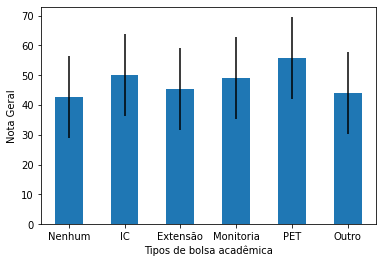

In [40]:
#Questao3 - Alunos com melhor nota no ENADE receberam bolsa?

bolsa_nota = microdados_sul.groupby(['QE_I13'])['NT_GER'].mean().plot(kind='bar',rot=0,yerr=microdados_sul.NT_GER.std())
bolsa_nota.set_ylabel('Nota Geral')
bolsa_nota.set_xlabel('Tipos de bolsa acadêmica')
bolsa_nota.set_xticklabels(abrev_qe13_dict.keys())

In [41]:
abrev_qe13_dict2 = {'IC':'Bolsa de iniciação científica','Extensão':'Bolsa de extensão','Monitoria':'Bolsa de monitoria','PET':'Bolsa PET','Outro':'Outro'}

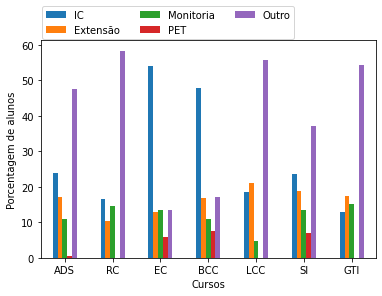

In [42]:
curso_bolsa = (microdados_sul.query('QE_I13 != "A"').groupby('CO_GRUPO').QE_I13.value_counts(normalize=True).fillna(0).round(4)*100).unstack().plot(kind='bar',rot=0)
curso_bolsa.set_ylabel('Porcentagem de alunos')
curso_bolsa.set_xlabel('Cursos')
curso_bolsa.set_xticklabels(cursos_abrev_dict.keys())
curso_bolsa.legend(labels=abrev_qe13_dict2.keys(),bbox_to_anchor=(0,1),borderaxespad=0.1,loc="lower left",ncol=3)

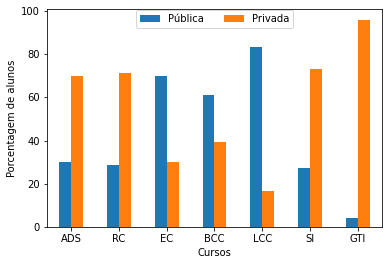

In [43]:
bolsa_ies = (microdados_sul.query('QE_I13 == "F"').groupby('CO_GRUPO').CO_CATEGAD.value_counts(normalize=True).fillna(0).round(4)*100).unstack().plot(kind='bar',rot=0) #alunos que recebem bolsa "outro"
bolsa_ies.set_ylabel('Porcentagem de alunos')
bolsa_ies.set_xlabel('Cursos')
bolsa_ies.set_xticklabels(cursos_abrev_dict.keys())
bolsa_ies.legend(labels=['Pública','Privada'],bbox_to_anchor=(0.5,1),loc="upper center",ncol=2,borderaxespad=0.1)

In [44]:
microdados_sul['BOLSA'] = microdados_sul['QE_I13']
microdados_sul['BOLSA'].replace({'C':'B','D':'B','E':'B','F':'B'},inplace=True) #todo tempo ou maior parte pub
bolsa_dict = {'A':'Não recebeu','B':'Recebeu'}

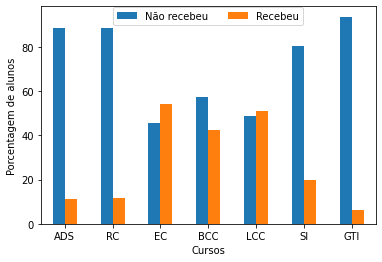

In [45]:
bolsa_curso = (microdados_sul.groupby('CO_GRUPO').BOLSA.value_counts(normalize=True).fillna(0).round(4)*100).unstack().plot(kind='bar',rot=0)
bolsa_curso.set_ylabel('Porcentagem de alunos')
bolsa_curso.set_xlabel('Cursos')
bolsa_curso.set_xticklabels(cursos_abrev_dict.keys())
bolsa_curso.legend(labels=bolsa_dict.values(),bbox_to_anchor=(0.5,1),loc="upper center",ncol=2,borderaxespad=0.1)

In [46]:
diretorio = '/questao3'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

descricao_bolsa.to_csv('.{}/{}.csv'.format(diretorio,'descricao_bolsa'),index=True)
qnt_bolsa.to_csv('.{}/{}.csv'.format(diretorio,'quantidade_alunos_bolsa'),index=True)
bolsa_nota.get_figure().savefig('.{}/{}.png'.format(diretorio,'bolsa_nota_ger'),dpi=300)
curso_bolsa.get_figure().savefig('.{}/{}.png'.format(diretorio,'curso_bolsas'),bbox_extra_artists=(curso_bolsa.get_legend(),), bbox_inches='tight',dpi=300)
bolsa_curso.get_figure().savefig('.{}/{}.png'.format(diretorio,'bolsa_ou_nao'),bbox_extra_artists=(bolsa_curso.get_legend(),), bbox_inches='tight',dpi=300)
bolsa_ies.get_figure().savefig('.{}/{}.png'.format(diretorio,'bolsa_OUTRO_IES'),bbox_extra_artists=(bolsa_ies.get_legend(),), bbox_inches='tight',dpi=300)

In [47]:
abrev_qe08_dict = {'Até 3':'Até 3 salários minimos','De 3 a 6':'De 3 a 6 salários minimos','De 6 a 30':'De 6 a 30 salários minimos','Mais de 30':'Mais de 30 salários minimos'}
qe08_translate = {'A':'Até 3','B':'De 3 a 6','C':'De 6 a 30','D':'Mais de 30'}

In [48]:
qnt_renda_familiar =  microdados_sul.QE_I08.value_counts().to_frame('Quantidade de alunos').rename(index=qe08_translate)

In [49]:
descricao_renda = pd.DataFrame.from_dict(abrev_qe08_dict,orient='index',columns=['Descrição'])

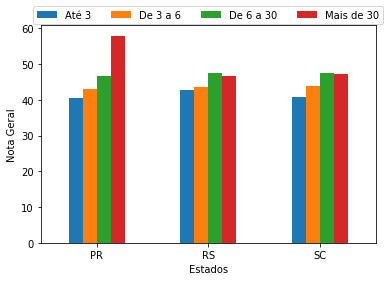

In [50]:
#Questao4 - A situaçao financeira influencia a nota no ENADE?

ger_mean = microdados_sul.groupby(['CO_UF_CURSO','QE_I08'])['NT_GER'].mean().unstack().plot(kind='bar',rot=0)
ger_mean.set_ylabel('Nota Geral')
ger_mean.set_xlabel('Estados')
ger_mean.legend(labels=qe08_translate.values(),bbox_to_anchor=(0.5,1),loc="lower center",borderaxespad=0.1,ncol=4)

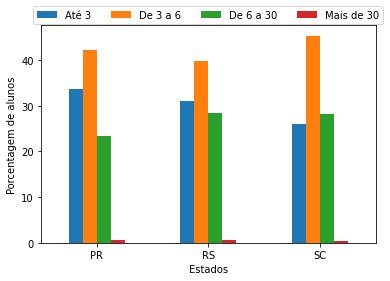

In [51]:
renda_estados = (microdados_sul.groupby('CO_UF_CURSO')['QE_I08'].value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
renda_estados.set_ylabel('Porcentagem de alunos')
renda_estados.set_xlabel('Estados')
renda_estados.legend(labels=qe08_translate.values(),bbox_to_anchor=(0.5,1),loc="lower center",borderaxespad=0.1,ncol=4)

In [52]:
diretorio = '/questao4'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

descricao_renda.to_csv('.{}/{}.csv'.format(diretorio,'descricao_renda_familiar'),index=True)
qnt_renda_familiar.to_csv('.{}/{}.csv'.format(diretorio,'quantidade_alunos_por_renda'),index=True)
ger_mean.get_figure().savefig('.{}/{}.png'.format(diretorio,'renda_nota'),bbox_extra_artists=(ger_mean.get_legend(),), bbox_inches='tight',dpi=300)
renda_estados.get_figure().savefig('.{}/{}.png'.format(diretorio,'renda_estados'),bbox_extra_artists=(renda_estados.get_legend(),), bbox_inches='tight',dpi=300)

In [53]:
#Quantidade de ensino medio
EM_abrev_dict = {'Pública':'Todo ou maior parte em escola pública','Privada':'Todo ou maior parte em escola privada','Exterior':'Todo ou maior parte no exterior'}
EM_translate = {'A':'Pública','B':'Privada','C':'Exterior'}

descricao_ensino_medio = pd.DataFrame.from_dict(EM_abrev_dict,orient='index',columns=['Descrição'])

In [54]:
qnt_alunos_EM = microdados_sul.QE_I17.value_counts().to_frame('Quantidade de alunos').rename(index=EM_translate)

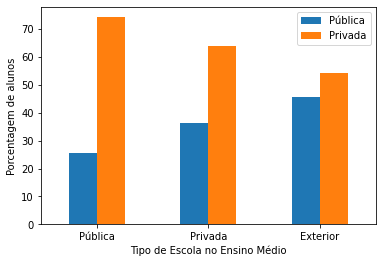

In [55]:
medio_universidade = (microdados_sul.groupby(['QE_I17']).CO_CATEGAD.value_counts(normalize=True).unstack().round(4)*100).plot(kind='bar',rot=0)
medio_universidade.set_ylabel('Porcentagem de alunos')
medio_universidade.set_xticklabels(EM_abrev_dict.keys())
medio_universidade.set_xlabel('Tipo de Escola no Ensino Médio')
medio_universidade.legend(bbox_to_anchor=(1,1),loc=0,labels=['Pública','Privada'])

In [56]:
#####NOVO
diretorio = '/questao5'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

descricao_ensino_medio.to_csv('.{}/{}.csv'.format(diretorio,'descricao_ensino_medio'),index=True)
qnt_alunos_EM.to_csv('.{}/{}.csv'.format(diretorio,'quantidade_alunos_por_ensino_medio'),index=True)
medio_universidade.get_figure().savefig('.{}/{}.png'.format(diretorio,'ensino_medio_tipo_instituicao'),dpi=300)

In [57]:
#Questao6
escolaridade_dict = {'A':'Nenhuma','B':'1° ao 5° ano EF','C':'6° ao 9° ano EF','D':'Ensino Médio','E':'Graduação','F':'Pós-graduação'}

In [58]:
a = microdados_sul.QE_I04.value_counts(sort=False).sort_index().rename(index=escolaridade_dict)
b = microdados_sul.QE_I05.value_counts(sort=False).sort_index().rename(index=escolaridade_dict)
a , b

(Nenhuma             206
 1° ao 5° ano EF    1470
 6° ao 9° ano EF    1232
 Ensino Médio       2728
 Graduação          1211
 Pós-graduação       451
 Name: QE_I04, dtype: int64,
 Nenhuma             108
 1° ao 5° ano EF    1331
 6° ao 9° ano EF    1206
 Ensino Médio       2662
 Graduação          1203
 Pós-graduação       788
 Name: QE_I05, dtype: int64)

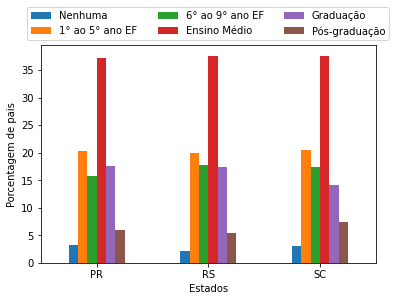

In [59]:
escolaridade_pai = (microdados_sul.groupby('CO_UF_CURSO').QE_I04.value_counts(normalize=True).unstack().round(4)*100).plot(kind='bar',rot=0)
escolaridade_pai.set_ylabel('Porcentagem de pais')
escolaridade_pai.set_xlabel('Estados')
escolaridade_pai.legend(labels=escolaridade_dict.values(),bbox_to_anchor=(0.5,1),loc="lower center",ncol=3)

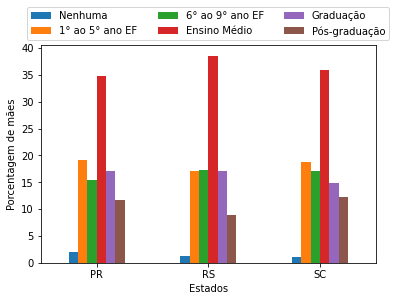

In [60]:
escolaridade_mae = (microdados_sul.groupby('CO_UF_CURSO').QE_I05.value_counts(normalize=True).unstack().round(4)*100).plot(kind='bar',rot=0)
escolaridade_mae.set_ylabel('Porcentagem de mães')
escolaridade_mae.set_xlabel('Estados')
escolaridade_mae.legend(labels=escolaridade_dict.values(),bbox_to_anchor=(0.5,1),loc="lower center",ncol=3)

Text(0.5, 0, 'Cursos')

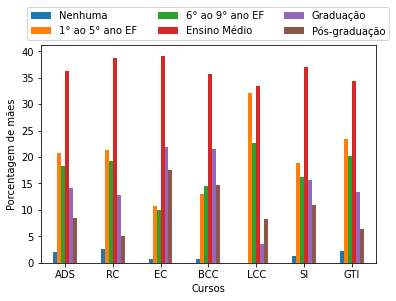

In [61]:
mamae = (microdados_sul.groupby('CO_GRUPO').QE_I05.value_counts(normalize=True).unstack().round(4)*100).plot(kind='bar',rot=0)
mamae.legend(labels=escolaridade_dict.values(),bbox_to_anchor=(0.5,1),loc="lower center",ncol=3)
mamae.set_xticklabels(cursos_abrev_dict.keys())
mamae.set_ylabel('Porcentagem de mães')
mamae.set_xlabel('Cursos')

Text(0.5, 0, 'Cursos')

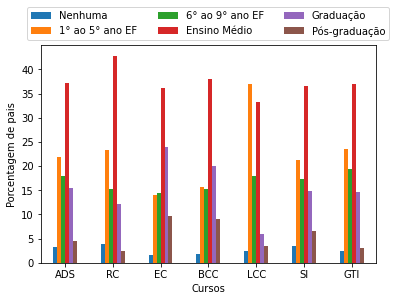

In [62]:
papai = (microdados_sul.groupby('CO_GRUPO').QE_I04.value_counts(normalize=True).unstack().round(4)*100).plot(kind='bar',rot=0)
papai.legend(labels=escolaridade_dict.values(),bbox_to_anchor=(0.5,1),loc="lower center",ncol=3)
papai.set_xticklabels(cursos_abrev_dict.keys())
papai.set_ylabel('Porcentagem de pais')
papai.set_xlabel('Cursos')

In [63]:
escolaridade_abrev_dict = {'A':'Nenhuma','B':'1°-5° ano','C':'6°-9° ano','D':'E.M.','E':'Graduação','F':'Pós'}

Text(0.5, 0, 'Escolaridade')

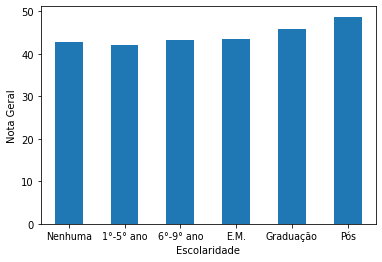

In [64]:
nota_pai = (microdados_sul.groupby('QE_I04').NT_GER.mean()).plot(kind='bar',rot=0)
nota_pai.set_xticklabels(escolaridade_abrev_dict.values(),fontsize=9.5)
nota_pai.set_ylabel('Nota Geral')
nota_pai.set_xlabel('Escolaridade')

Text(0.5, 0, 'Escolaridade')

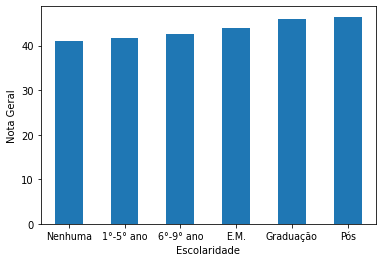

In [65]:
nota_mae = (microdados_sul.groupby('QE_I05').NT_GER.mean()).plot(kind='bar',rot=0)
nota_mae.set_xticklabels(escolaridade_abrev_dict.values(),fontsize=9.5)
nota_mae.set_ylabel('Nota Geral')
nota_mae.set_xlabel('Escolaridade')

In [66]:
diretorio = '/questao6'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

nota_mae.get_figure().savefig('.{}/{}.png'.format(diretorio,'nota_mae'),dpi=300)
nota_pai.get_figure().savefig('.{}/{}.png'.format(diretorio,'nota_pai'),dpi=300)
escolaridade_mae.get_figure().savefig('.{}/{}.png'.format(diretorio,'escolaridade_mãe'),bbox_extra_artists=(escolaridade_mae.get_legend(),), bbox_inches='tight',dpi=300)
escolaridade_pai.get_figure().savefig('.{}/{}.png'.format(diretorio,'escolaridade_pai'),bbox_extra_artists=(escolaridade_pai.get_legend(),), bbox_inches='tight',dpi=300)
mamae.get_figure().savefig('.{}/{}.png'.format(diretorio,'mamae'),bbox_extra_artists=(mamae.get_legend(),), bbox_inches='tight',dpi=300)
papai.get_figure().savefig('.{}/{}.png'.format(diretorio,'papai'),bbox_extra_artists=(papai.get_legend(),), bbox_inches='tight',dpi=300)

In [67]:
# idade e motivacao
microdados_sul['IDADE_OLD'] = microdados_sul['NU_IDADE']
idade_pre = microdados_sul['NU_IDADE'].value_counts()
idade_pre.idxmax()

22

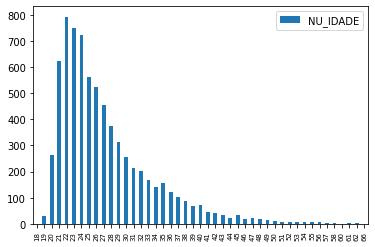

In [68]:
a = idade_pre.to_frame().sort_index().plot(kind='bar',rot=90)
a.tick_params(axis='x', labelsize='x-small')

In [69]:
# http://portal.inep.gov.br/artigo/-/asset_publisher/B4AQV9zFY7Bv/content/portaria-do-enade-anuncia-cursos-avaliados-em-2017/21206

In [70]:
microdados_sul['NU_IDADE'].replace({18:'A',19:'A',20:'A',21:'A',22:'A',23:'A',24:'A',25:'A',26:'A'},inplace=True) #publica
microdados_sul['NU_IDADE'].replace({27:'B',28:'B',29:'B',30:'B',31:'B',32:'B',33:'B',34:'B'},inplace=True) #publica 
microdados_sul['NU_IDADE'].replace({35:'C',36:'C',37:'C',38:'C',39:'C',40:'C',41:'C',42:'C'},inplace=True) #publica 
microdados_sul['NU_IDADE'].replace({43:'D',44:'D',45:'D',46:'D',47:'D',48:'D',49:'D',50:'D'},inplace=True) #publica 
microdados_sul['NU_IDADE'].replace({51:'E',52:'E',53:'E',54:'E',55:'E',56:'E',57:'E',58:'E'},inplace=True) #publica 
microdados_sul['NU_IDADE'].replace({59:'F',60:'F',61:'F',62:'F',63:'F',64:'F',65:'F',66:'F'},inplace=True) #publica 

In [71]:
microdados_sul['NU_IDADE'].value_counts()

A    4267
B    2115
C     694
D     174
E      42
F       6
Name: NU_IDADE, dtype: int64

In [72]:
idade_dict = {'A':'18-26','B':'27-34','C':'35-42','D':'43-50','E':'51-58','F':'59-66'}

In [73]:
idade_curso_pre = microdados_sul.groupby('CO_GRUPO').NU_IDADE.value_counts(normalize=True).unstack().fillna(0).round(4)*100

In [74]:
idade_curso_pre['sum'] = idade_curso_pre['A']+idade_curso_pre['B']+idade_curso_pre['C']+idade_curso_pre['D']+idade_curso_pre['E']+idade_curso_pre['F']
idade_curso_pre.rename(index=cursos_dict,columns=idade_dict)

NU_IDADE,18-26,27-34,35-42,43-50,51-58,59-66,sum
CO_GRUPO,,,,,,,
ADS,51.25,31.86,12.19,3.50,1.01,0.19,100.00
RC,40.88,40.15,13.87,3.89,0.97,0.24,100.00
EC,74.36,21.71,2.91,0.85,0.17,0.00,100.00
BCC,73.53,21.74,4.16,0.57,0.00,0.00,100.00
LCC,60.71,25.00,11.90,2.38,0.00,0.00,99.99
SI,63.33,29.28,6.24,0.93,0.22,0.00,100.00
GTI,30.69,35.83,24.44,7.22,1.67,0.14,99.99


In [75]:
teste = microdados_sul.groupby('NU_IDADE').CO_GRUPO.value_counts(normalize=True).unstack().fillna(0).round(4)*100
teste.rename(columns=cursos_dict,index=idade_dict)

CO_GRUPO,ADS,RC,EC,BCC,LCC,SI,GTI
NU_IDADE,,,,,,,
18-26,25.03,3.94,10.19,27.35,1.20,27.12,5.18
27-34,31.39,7.80,6.00,16.31,0.99,25.30,12.20
35-42,36.60,8.21,2.45,9.51,1.44,16.43,25.36
43-50,41.95,9.20,2.87,5.17,1.15,9.77,29.89
51-58,50.00,9.52,2.38,0.00,0.00,9.52,28.57
59-66,66.67,16.67,0.00,0.00,0.00,0.00,16.67


Text(0.5, 0, 'Estados')

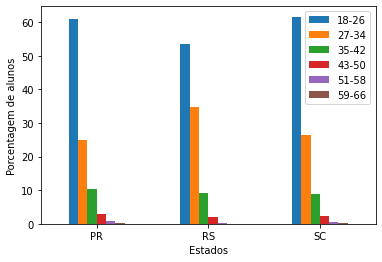

In [76]:
idade_faixa = (microdados_sul.groupby('CO_UF_CURSO').NU_IDADE.value_counts(normalize=True).unstack().round(4)*100).plot(kind='bar',rot=0)
idade_faixa.legend(labels=idade_dict.values(),bbox_to_anchor=(0.775,1),loc=2)
idade_faixa.set_ylabel('Porcentagem de alunos')
idade_faixa.set_xlabel('Estados')

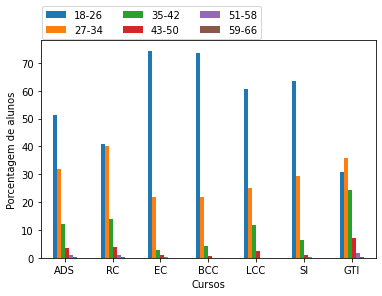

In [77]:
curso_idade = (microdados_sul.groupby('CO_GRUPO').NU_IDADE.value_counts(normalize=True).unstack().round(4)*100).plot(kind='bar',rot=0)
curso_idade.set_ylabel('Porcentagem de alunos')
curso_idade.set_xlabel('Cursos')
curso_idade.set_xticklabels(cursos_abrev_dict.keys())
curso_idade.legend(labels=idade_dict.values(),bbox_to_anchor=(0,1),loc="lower left",ncol=3,borderaxespad=0.1)

[Text(0, 0, '18-26'),
 Text(1, 0, '27-34'),
 Text(2, 0, '35-42'),
 Text(3, 0, '43-50'),
 Text(4, 0, '51-58'),
 Text(5, 0, '59-66')]

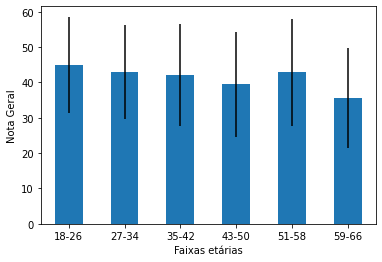

In [78]:
idade_nota = (microdados_sul.groupby('NU_IDADE').NT_GER.mean()).plot(kind='bar',rot=0,yerr=microdados_sul.groupby('NU_IDADE')['NT_GER'].std())
idade_nota.set_ylabel('Nota Geral')
idade_nota.set_xlabel('Faixas etárias')
idade_nota.set_xticklabels(idade_dict.values())

In [79]:
microdados_sul['NU_IDADE'].value_counts()

A    4267
B    2115
C     694
D     174
E      42
F       6
Name: NU_IDADE, dtype: int64

In [80]:
diretorio = '/idade'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

curso_idade.get_figure().savefig('.{}/{}.png'.format(diretorio,'cursos_idades'),bbox_extra_artists=(curso_idade.get_legend(),), bbox_inches='tight',dpi=300)
idade_nota.get_figure().savefig('.{}/{}.png'.format(diretorio,'idade_nota'),dpi=300)
idade_faixa.get_figure().savefig('.{}/{}.png'.format(diretorio,'faixa_etaria'),bbox_extra_artists=(idade_faixa.get_legend(),), bbox_inches='tight',dpi=300)

In [81]:
modalidade_dict = {0:'EAD',1:'Presencial'}

In [82]:
microdados_sul.CO_MODALIDADE.value_counts()

1    6115
0    1183
Name: CO_MODALIDADE, dtype: int64

In [83]:
microdados_sul.groupby('CO_MODALIDADE').CO_CURSO.nunique()

CO_MODALIDADE
0     14
1    299
Name: CO_CURSO, dtype: int64

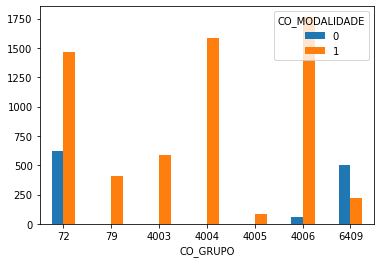

In [84]:
k= (microdados_sul.groupby('CO_GRUPO').CO_MODALIDADE.value_counts().unstack().fillna(0).astype(int)).plot(kind='bar',rot=0)

[Text(0, 0, 'ADS'),
 Text(1, 0, 'RC'),
 Text(2, 0, 'EC'),
 Text(3, 0, 'BCC'),
 Text(4, 0, 'LCC'),
 Text(5, 0, 'SI'),
 Text(6, 0, 'GTI')]

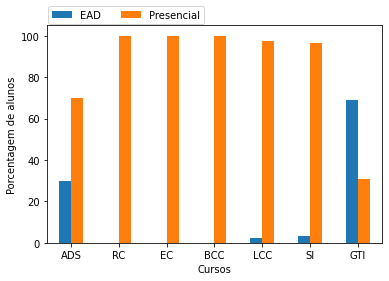

In [85]:
modalidade_curso = (microdados_sul.groupby('CO_GRUPO').CO_MODALIDADE.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
modalidade_curso.legend(labels=modalidade_dict.values(),bbox_to_anchor=(0,1),loc="lower left",borderaxespad=0.1,ncol=2)
modalidade_curso.set_ylabel('Porcentagem de alunos')
modalidade_curso.set_xlabel('Cursos')
modalidade_curso.set_xticklabels(cursos_abrev_dict.keys())

In [86]:
for i,p in zip(k.patches,modalidade_curso.patches):
        
    x = p.get_x() + (p.get_width()/2)
    y = p.get_y() + p.get_height() + 0.5
    modalidade_curso.annotate(i.get_height(), (x, y),fontsize=8,ha='center')

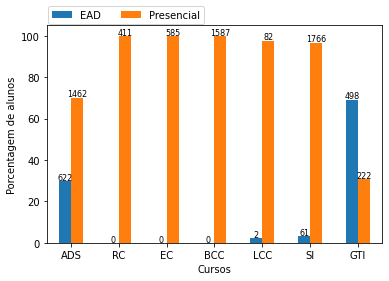

In [87]:
modalidade_curso.get_figure()

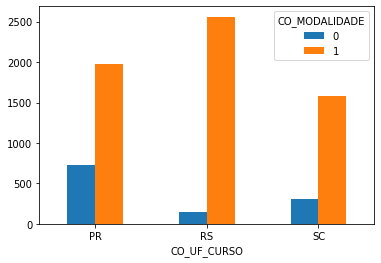

In [88]:
j = (microdados_sul.groupby('CO_UF_CURSO').CO_MODALIDADE.value_counts().unstack().fillna(0)).plot(kind='bar',rot=0)

Text(0.5, 0, 'Estados')

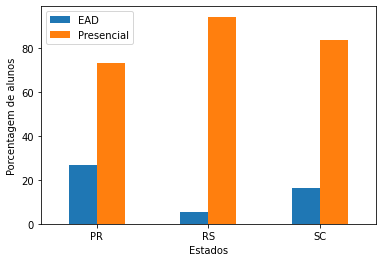

In [89]:
modalidade_estado = (microdados_sul.groupby('CO_UF_CURSO').CO_MODALIDADE.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
modalidade_estado.legend(labels=modalidade_dict.values(),bbox_to_anchor=(0,1),loc=2)
modalidade_estado.set_ylabel('Porcentagem de alunos')
modalidade_estado.set_xlabel('Estados')

In [90]:
for i,p in zip(j.patches,modalidade_estado.patches):
        
    x = p.get_x() + (p.get_width()/2)
    y = p.get_y() + p.get_height() + 0.8
    modalidade_estado.annotate(i.get_height(), (x, y),fontsize=10,ha='center')

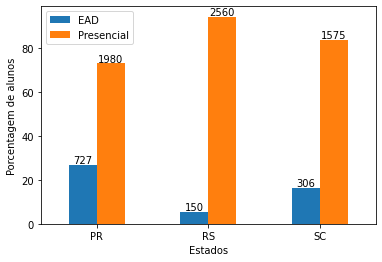

In [91]:
modalidade_estado.get_figure()

In [92]:
cursos_ead = {72: 'ADS',4005:'LCC',4006: 'SI',6409: 'GTI'}

[Text(0, 0, 'ADS'), Text(1, 0, 'LCC'), Text(2, 0, 'SI'), Text(3, 0, 'GTI')]

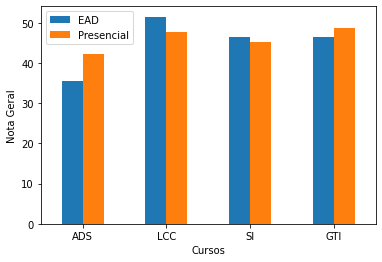

In [93]:
nota_ead = (microdados_sul.query('CO_GRUPO != 79 & CO_GRUPO != 4003 & CO_GRUPO != 4004').groupby(['CO_GRUPO','CO_MODALIDADE']).NT_GER.mean().unstack()).plot(kind='bar',rot=0)
nota_ead.legend(labels=modalidade_dict.values(),bbox_to_anchor=(0,1),loc=2)
nota_ead.set_ylabel('Nota Geral')
nota_ead.set_xlabel('Cursos')
nota_ead.set_xticklabels(cursos_ead.values())

In [94]:
diretorio = '/modalidade'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

modalidade_curso.get_figure().savefig('.{}/{}.png'.format(diretorio,'modalidade_curso'),bbox_extra_artists=(modalidade_curso.get_legend(),), bbox_inches='tight',dpi=300)
modalidade_estado.get_figure().savefig('.{}/{}.png'.format(diretorio,'modalidade_estado'),bbox_extra_artists=(modalidade_estado.get_legend(),), bbox_inches='tight',dpi=300)
nota_ead.get_figure().savefig('.{}/{}.png'.format(diretorio,'nota_ead'),bbox_extra_artists=(nota_ead.get_legend(),), bbox_inches='tight',dpi=300)

In [95]:
# ANO_FIM_EM ANO_IN_GRAD
fim_medio = microdados_sul.groupby('CO_GRUPO').ANO_FIM_EM.mean().astype(int).to_frame().rename(index=cursos_dict)
fim_medio

,ANO_FIM_EM
CO_GRUPO,
ADS,2007
RC,2006
EC,2008
BCC,2009
LCC,2008
SI,2008
GTI,2004


In [96]:
microdados_sul['INGRESSO'] = microdados_sul['ANO_IN_GRAD'] - microdados_sul['ANO_FIM_EM'] #tempo que leva para entrar na faculdade

In [97]:
microdados_sul.groupby('CO_UF_CURSO').INGRESSO.max().astype(int).to_frame().rename(index=cursos_dict)

,INGRESSO
CO_UF_CURSO,
PR,36
RS,35
SC,37


In [98]:
ingresso = microdados_sul.groupby('CO_GRUPO').INGRESSO.mean().astype(int).to_frame().rename(index=cursos_dict)

In [99]:
diretorio = '/ingresso_IES'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

fim_medio.to_csv('.{}/{}.csv'.format(diretorio,'ano_fim_EM'),index=True)
ingresso.to_csv('.{}/{}.csv'.format(diretorio,'tempo_para_ingressar'),index=True)

In [100]:
turno_dict = {1:'Matutino',2:'Vespertino',3:'Integral',4:'Noturno'}

In [101]:
(microdados_sul.CO_TURNO_GRADUACAO.value_counts(normalize=True).fillna(0).round(4)*100).to_frame().rename(turno_dict)

,CO_TURNO_GRADUACAO
Noturno,75.95
Integral,17.63
Matutino,5.93
Vespertino,0.49


[Text(0, 0, 'ADS'),
 Text(1, 0, 'RC'),
 Text(2, 0, 'EC'),
 Text(3, 0, 'BCC'),
 Text(4, 0, 'LCC'),
 Text(5, 0, 'SI'),
 Text(6, 0, 'GTI')]

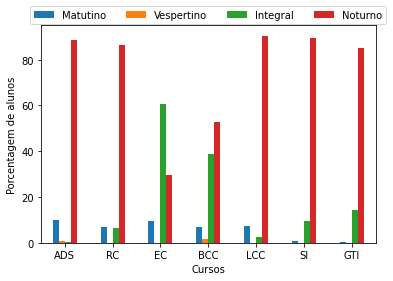

In [102]:
# CO_TURNO_GRADUACAO
turno_curso = (microdados_sul.groupby('CO_GRUPO').CO_TURNO_GRADUACAO.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
turno_curso.legend(turno_dict.values(),bbox_to_anchor=(0.5,1),borderaxespad=0.1,loc="lower center",ncol=4)
turno_curso.set_ylabel('Porcentagem de alunos')
turno_curso.set_xlabel('Cursos')
turno_curso.set_xticklabels(cursos_abrev_dict.keys())

[Text(0, 0, '18-26'),
 Text(1, 0, '27-34'),
 Text(2, 0, '35-42'),
 Text(3, 0, '43-50'),
 Text(4, 0, '51-58'),
 Text(5, 0, '59-66')]

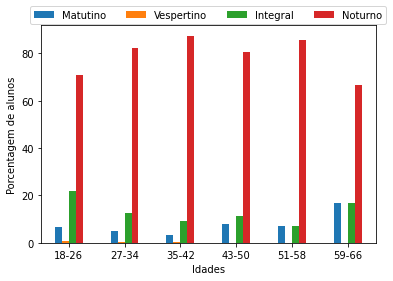

In [103]:
turno_idade = (microdados_sul.groupby('NU_IDADE').CO_TURNO_GRADUACAO.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
turno_idade.legend(turno_dict.values(),bbox_to_anchor=(0.5,1),borderaxespad=0.1,loc="lower center",ncol=4)
turno_idade.set_ylabel('Porcentagem de alunos')
turno_idade.set_xlabel('Idades')
turno_idade.set_xticklabels(idade_dict.values())

[Text(0, 0, 'Matutino'),
 Text(1, 0, 'Vespertino'),
 Text(2, 0, 'Integral'),
 Text(3, 0, 'Noturno')]

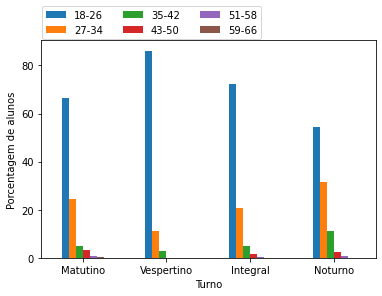

In [104]:
turno_idade2 = (microdados_sul.groupby('CO_TURNO_GRADUACAO').NU_IDADE.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
turno_idade2.legend(idade_dict.values(),bbox_to_anchor=(0,1),loc="lower left",ncol=3,borderaxespad=0.1)
turno_idade2.set_ylabel('Porcentagem de alunos')
turno_idade2.set_xlabel('Turno')
turno_idade2.set_xticklabels(turno_dict.values())

[Text(0, 0, 'Matutino'),
 Text(1, 0, 'Vespertino'),
 Text(2, 0, 'Integral'),
 Text(3, 0, 'Noturno')]

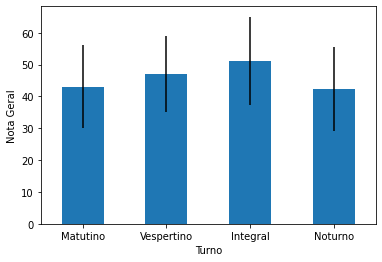

In [105]:
turno_nota = (microdados_sul.groupby('CO_TURNO_GRADUACAO').NT_GER.mean()).plot(kind='bar',yerr=microdados_sul.groupby('CO_TURNO_GRADUACAO').NT_GER.std(),rot=0)
turno_nota.set_ylabel('Nota Geral')
turno_nota.set_xlabel('Turno')
turno_nota.set_xticklabels(turno_dict.values())

Text(0.5, 0, 'Estados')

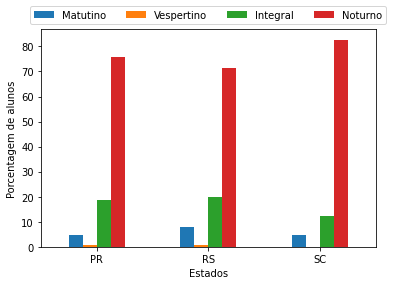

In [106]:
turno_estado = (microdados_sul.groupby('CO_UF_CURSO').CO_TURNO_GRADUACAO.value_counts(normalize=True).unstack().fillna(0).round(4)*100).plot(kind='bar',rot=0)
turno_estado.legend(turno_dict.values(),bbox_to_anchor=(0.5,1),loc="lower center",ncol=4)
turno_estado.set_ylabel('Porcentagem de alunos')
turno_estado.set_xlabel('Estados')

In [107]:
diretorio = '/turno'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

turno_curso.get_figure().savefig('.{}/{}.png'.format(diretorio,'turno_curso'),bbox_extra_artists=(turno_curso.get_legend(),), bbox_inches='tight',dpi=300)
turno_idade2.get_figure().savefig('.{}/{}.png'.format(diretorio,'turno_idade'),bbox_extra_artists=(turno_idade2.get_legend(),), bbox_inches='tight',dpi=300)
turno_nota.get_figure().savefig('.{}/{}.png'.format(diretorio,'turno_nota'),dpi=300)
turno_estado.get_figure().savefig('.{}/{}.png'.format(diretorio,'turno_estado'),bbox_extra_artists=(turno_estado.get_legend(),), bbox_inches='tight',dpi=300)

In [108]:
microdados_sul.groupby(['CO_GRUPO','CO_TURNO_GRADUACAO']).CO_CURSO.nunique().unstack()

CO_TURNO_GRADUACAO,1.0,2.0,3.0,4.0
CO_GRUPO,,,,
72,19.0,1.0,3.0,76.0
79,2.0,NaN,2.0,23.0
4003,5.0,NaN,10.0,12.0
4004,9.0,3.0,19.0,41.0
4005,2.0,NaN,1.0,7.0
4006,3.0,NaN,6.0,78.0
6409,2.0,NaN,2.0,16.0


In [109]:
microdados_sul.groupby(['CO_TURNO_GRADUACAO']).CO_CURSO.nunique()

CO_TURNO_GRADUACAO
1.0     42
2.0      4
3.0     43
4.0    253
Name: CO_CURSO, dtype: int64

In [110]:
microdados_sul.groupby(['CO_UF_CURSO','CO_TURNO_GRADUACAO']).CO_CURSO.nunique().unstack()

CO_TURNO_GRADUACAO,1.0,2.0,3.0,4.0
CO_UF_CURSO,,,,
PR,15.0,2.0,16.0,87.0
RS,19.0,2.0,20.0,102.0
SC,8.0,NaN,7.0,64.0


In [111]:
microdados_sul.groupby(['CO_TURNO_GRADUACAO']).CO_CATEGAD.value_counts(normalize=True).unstack()


CO_CATEGAD,0,1
CO_TURNO_GRADUACAO,,
1.0,0.405093,0.594907
2.0,0.583333,0.416667
3.0,0.810895,0.189105
4.0,0.153388,0.846612


In [112]:
microdados_sul.CO_UF_CURSO.value_counts()

RS    2710
PR    2707
SC    1881
Name: CO_UF_CURSO, dtype: int64

In [113]:
analise_27_34 = microdados_sul.query('NU_IDADE == "B"').groupby(['CO_GRUPO']).CO_UF_CURSO.value_counts(normalize=True).unstack().round(4)*100
analise_27_34 = analise_27_34.rename(index=cursos_dict)

In [114]:
analise_rs = microdados_sul.query('CO_UF_CURSO == "RS"').groupby(['CO_GRUPO']).NU_IDADE.value_counts(normalize=True).unstack().fillna(0).round(4)*100
analise_rs = analise_rs.rename(columns=idade_dict,index=cursos_dict)

In [115]:
analise_geral = microdados_sul.groupby(['CO_UF_CURSO','CO_GRUPO']).NU_IDADE.value_counts(normalize=True).unstack().fillna(0).round(4)*100
analise_geral = analise_geral.rename(columns=idade_dict)
analise_geral = analise_geral.rename(index=cursos_dict)
analise_geral

NU_IDADE              18-26  27-34  35-42  43-50  51-58  59-66
CO_UF_CURSO CO_GRUPO                                          
PR          ADS       49.69  31.38  13.06   3.94   1.67   0.26
            RC        52.78  25.00  16.67   5.56   0.00   0.00
            EC        82.67  14.67   2.22   0.44   0.00   0.00
            BCC       85.75  11.06   2.70   0.49   0.00   0.00
            LCC       63.83  23.40  10.64   2.13   0.00   0.00
            SI        72.56  21.62   5.08   0.75   0.00   0.00
            GTI       36.05  32.29  23.82   6.90   0.94   0.00
RS          ADS       53.53  33.29  10.33   2.45   0.27   0.14
            RC        33.20  46.56  15.38   3.24   1.62   0.00
            EC        64.49  28.97   4.21   1.87   0.47   0.00
            BCC       64.95  28.46   5.93   0.66   0.00   0.00
            LCC       57.14  25.71  14.29   2.86   0.00   0.00
            SI        49.59  39.35   9.11   1.63   0.33   0.00
            GTI       22.12  50.96  20.19   5.77   0.96   0.00
SC          ADS       51.69  29.47  14.01   4.83   0.00   0.00
            RC        52.34  32.03  10.16   4.69   0.00   0.78
            EC        76.03  21.92   2.05   0.00   0.00   0.00
            BCC       77.20  19.95   2.38   0.48   0.00   0.00
            LCC       50.00  50.00   0.00   0.00   0.00   0.00
            SI        68.53  26.18   4.56   0.44   0.29   0.00
            GTI       27.95  34.34  26.60   8.08   2.69   0.34

In [116]:
diretorio = '/analise_idade'

try:
    os.mkdir(os.getcwd()+diretorio,0o777) #criando um diretorio para a questao
except OSError as error:  
    print(error)

analise_27_34.to_csv('.{}/{}.csv'.format(diretorio,'analise_27_34'),index=True)
analise_rs.to_csv('.{}/{}.csv'.format(diretorio,'analise_rs'),index=True)
analise_geral.to_csv('.{}/{}.csv'.format(diretorio,'analise_geral'),index=True)